In [ ]:
############################# DRIVE PATH #################################
from google.colab import drive
drive.mount('/content/drive')
#the following line has to be changed to fit your Google drive organization
%cd 'drive/My Drive/Colab Notebooks/projet Adversarial/assignment3-aurele_julien_meriem/'
##########################################################################

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/projet Adversarial/assignment3-aurele_julien_meriem


In [ ]:
from model import Model
from attacks import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.utils
import seaborn as sns
import pandas as pd

In [ ]:
net = Model()
net.loadModel()
net.loadData(bs=1)
net.testModel()

classes = net.dataset.classes
classes

cuda:0
Files already downloaded and verified
Accuracy of the network on the 10000 test images: 76 %


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
#FGSM PARAMTERS:
fgsm_params={'eps':0.05}
fgsm = FGSM_Attack(net)

In [ ]:
# Attack twice and build dataframe of confidence for future plots
origines = []
targets = []
confidences = []
adversarial = [] 
best_adv_matrix = np.zeros((10,10))

for data in net.testset:
    img_src, label = data
    if net.identify(img_src) != label: #no need to attack if already wrong
        continue

    img = img_src / 2 + 0.5     # unnormalize

    conf_list = [0]*10

    #try attack for all targets
    for target in range(10):
        new_img = fgsm.generate_adv((img_src[None, ...]).to(net.device),
                                        torch.tensor([target]).to(net.device),
                                        targeted = True,
                                        **fgsm_params)
        new_img = new_img[0]
        with torch.no_grad():
            new_img = new_img[None, ...]
            new_img = new_img.to(net.device)
            pred = net.model(new_img)
        final_confidence_target = nn.Softmax(dim=1)(pred)[0,target]
        conf_list[target] = final_confidence_target.item()
        
        #append the lists
        confidences.append(final_confidence_target.item())
        targets.append(target)
        origines.append(label)
        adversarial.append("original")
    
    #look for the best adversarial class and produce the image
    conf_list[label] = 0
    best_adv = conf_list.index(max(conf_list))
    #Save that in the matrix
    best_adv_matrix[label,best_adv]+=1
    img_src = fgsm.generate_adv((img_src[None, ...]).to(net.device),
                                torch.tensor([best_adv]).to(net.device),
                                targeted = True,
                                **fgsm_params)
    img_src = img_src[0]
    # Attack again with all the targets on the adversarial example
    for target in range(10):
        new_img = fgsm.generate_adv((img_src[None, ...]).to(net.device),
                                        torch.tensor([target]).to(net.device),
                                        targeted = True,
                                        **fgsm_params)
        new_img = new_img[0]
        with torch.no_grad():
            new_img = new_img[None, ...]
            new_img = new_img.to(net.device)
            pred = net.model(new_img)
        final_confidence_target = nn.Softmax(dim=1)(pred)[0,target]
        conf_list[target] = final_confidence_target.item()
        
        #append the lists
        confidences.append(final_confidence_target.item())
        targets.append(target)
        origines.append(label)
        adversarial.append(best_adv)
    
    #attack again this adversarial example towards all classes

df = pd.DataFrame(list(zip(origines, adversarial, targets, confidences)), 
               columns =['origin', 'adversarial', 'target', 'confidence']) 

[[  0.  72. 218.  12.  93.   4.  33.  39. 216. 106.]
 [ 59.   0.  11.   3.  18.   8.  61.  20. 112. 602.]
 [ 71.  16.   0.  24. 158.  82. 200.  51.  35.  31.]
 [  9.  13.  43.   0.  67.  95. 127.  43.  27.  71.]
 [ 14.  14. 102.  14.   0.  27. 311. 166.  28.  31.]
 [  9.  23. 141.  79.  46.   0. 128. 153.  40.  73.]
 [ 18.  82. 127.  69. 279.  41.   0.  62.  37. 140.]
 [ 34.  61. 102.  14. 191. 159.  64.   0.  14. 151.]
 [328. 121.  66.   8.  64.   5.  31.  14.   0. 207.]
 [ 72. 468.  17.  10.  16.   8.  33. 118. 126.   0.]]


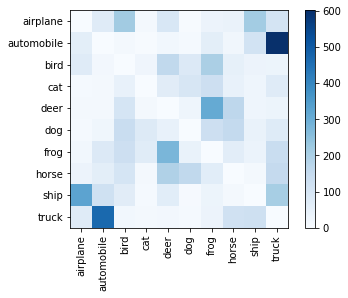

In [ ]:
plt.xticks(ticks=np.arange(len(classes)),labels=classes,rotation=90)
plt.yticks(ticks=np.arange(len(classes)),labels=classes)
hm = plt.imshow(best_adv_matrix, cmap='Blues',interpolation="nearest")
plt.colorbar(hm)

In [ ]:
def classeName(i):
  if i == "original":
    return "original"
  return classes[i]

df['origin']=df['origin'].apply(classeName)
df['target']=df['target'].apply(classeName)
df['adversarial']=df['adversarial'].apply(classeName)
df = df.sort_values(['origin', 'adversarial', 'target'])

df.to_csv('test_data_adversarial_confidences.csv')

Examples of the origin class (truck):  868.0
Examples of the target class (automobile):  894.0
Examples of original class truck dressed in automobile: 468.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


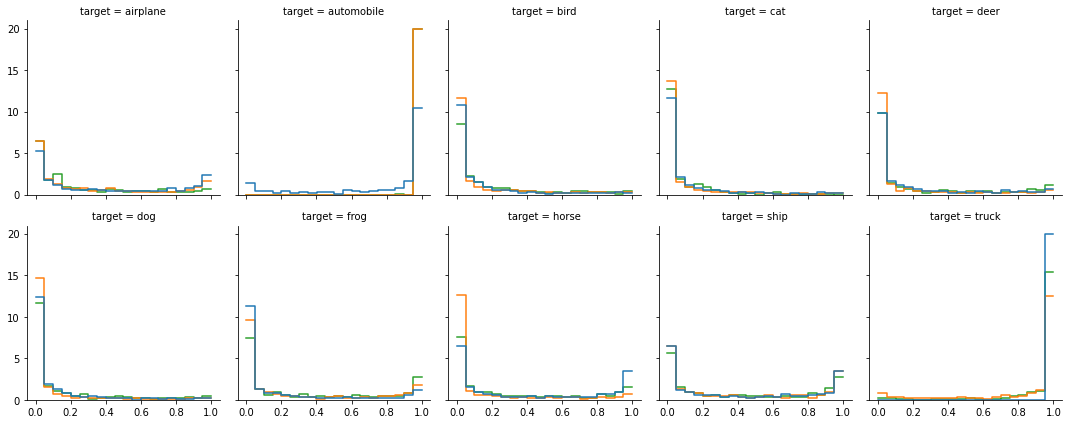

In [ ]:
df = pd.read_csv("test_data_adversarial_confidences.csv") 
#Chose a pair origin/target and plot adversarial signature histograms
classe_origin = 'truck'
classe_target = 'automobile'

print('Examples of the origin class ('+classe_origin+'): ', df[(df['origin']==classe_origin) & (df['adversarial']=="original")].shape[0]/10)
#devide by ten because 10 lines per example
print('Examples of the target class ('+classe_target+'): ', df[(df['origin']==classe_target) & (df['adversarial']=="original")].shape[0]/10)
print('Examples of original class '+classe_origin+' dressed in '+classe_target+':', df[(df['origin']==classe_origin) & (df['adversarial']==classe_target)].shape[0]/10)

sub_df = df[(((df['origin']==classe_origin) |(df['origin']==classe_target)) & (df['adversarial']=="original")) | ((df['origin']==classe_origin) & (df['adversarial']==classe_target))]
sub_df['adversarial'] = sub_df['origin']+'->'+sub_df['adversarial']
sub_df.to_csv('test.csv')

g = sns.FacetGrid(sub_df, col="target", col_wrap=5)
ordre_legend = [classe_origin+'->original', classe_target+'->original', classe_origin+'->'+classe_target]
g.map_dataframe(sns.histplot, x="confidence",hue='adversarial', binwidth=0.05, stat = 'density', hue_order = ordre_legend, common_norm=False, fill=False, element = 'step')